In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.cluster import KMeans
from sklearn.datasets.samples_generator import make_blobs
from sklearn.datasets import load_sample_image
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### 1. k-means on digits

Use K-means clustering on the MNIST dataset (which can be imported with `from sklearn.datasets import load_digits`) to learn to identify the 10 digits in an unsupervised manner.

1. Plot the `cluster_centers_` from a kmeans clustering (which should be shape `(10,64)`) onto a `8x8` grid (hint: use `kmeans.cluster_centers_.reshape`)

2. Reorganize the clusters so that each of your learned clusters labels overlap with the true label (eg. if the digit 4 has the cluster label 9, you want to remap it to 4). Hint: You can use the statistical mode of your clusters and the real label to match them

3. Now that your cluster labels are matched to the supervised learning labels, check the classification accuracy of your clustering model (accuracy score and confusion matrix). Give a two paragraph interpretation.

4. Use the Fowlkes-Mallows score to evaluate your clustering against the true labels. Give a two paragraph interpretation comparing to your result in #3.

In [4]:
# received help from Jasleen

In [5]:
digits = load_digits()

In [6]:
digits.data.shape

(1797, 64)

In [7]:
X = digits.data
y = digits.target

In [8]:
pca = PCA(2)
new_X = pca.fit_transform(X)

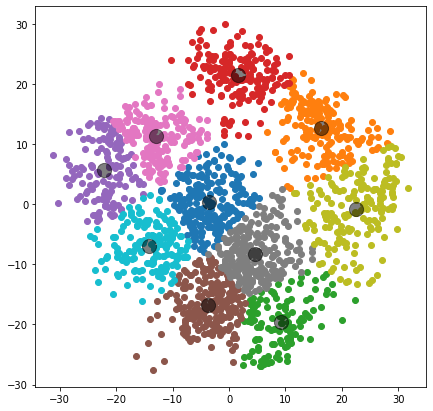

In [9]:
plt.figure(figsize=(7,7))

N_CLUSTERS = len(digits.target_names)
kmeans = KMeans(n_clusters=N_CLUSTERS)

predict_X = kmeans.fit_predict(new_X)

centers = kmeans.cluster_centers_

for i in np.unique(predict_X):
    plt.scatter(new_X[predict_X == i, 0], new_X[predict_X == i, 1], label = i)
    
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.show();

### 2: Image Compression second pass

Use any the clustering algorithms we see to produce what you think is the best image compression ratio that is **visually indistinguishable** from the original image (recall in the lecture the result was very compressed but also much uglier)

Justify your choice and process in 3 paragraphs.

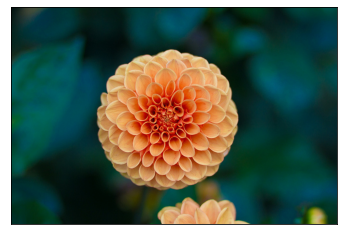

In [87]:
flower = load_sample_image("flower.jpg")
ax = plt.axes(xticks=[], yticks=[]) # erases the ticks
ax.imshow(flower); # shows the image

In [88]:
flower.shape
# height, width, rgb (max points?)

(427, 640, 3)

In [89]:
data = flower / 255 # all points are on a scale of 0 to 255, divide by 255 to make it between 0 and 1 (kmeans likes it)
data = data.reshape(427 * 640, 3) # ?
data.shape

(273280, 3)

In [90]:
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(256)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

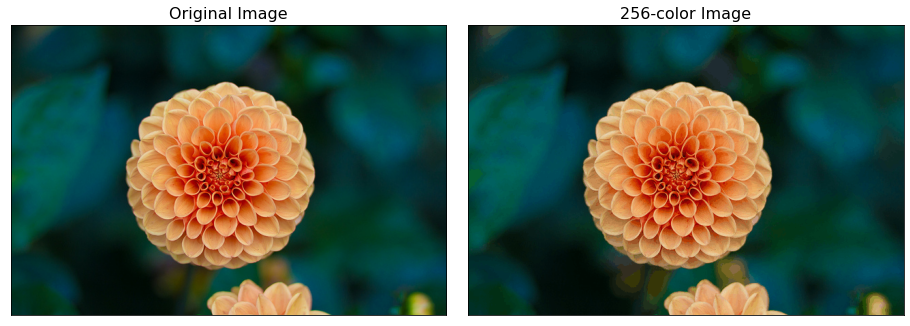

In [91]:
flower_recolored = new_colors.reshape(flower.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(flower)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(flower_recolored)
ax[1].set_title('256-color Image', size=16);

## Answer:
The best compression ratio is (according to a quick google search) 1.5:1 and 3:1 for total lossless compression. However sklearn isn't able to handle that kind of ratio, best we can do is (almost but not quite) 1:1. I've set it to run with 256 colors, which is about as high as it can go. Setting it to a higher number doesn't have an effect, and setting it too high breaks it. 

The picture is almost indistinguishable but not entirely, if we look closely we can see the background is a bit more blurry and the colors are less defined. Also at the bottom of the picture, between the circular flower and the few petals on the bottom, we can see a loss in quality due to the compression.

After running a few tests, anything under 256 results in a very significant loss of color/quality. The best way to make it as visually accurate to the original is to compress it with the maximum amount of colors, i.e. 256.

Bonus: running it at 2 colors makes it look artsy.

# 3. Clustering on Colleges

This question will use the data from `college.csv`

1. Use clustering with `k=2` on all data except whether the college is private or not. Try to match it best to the private/public college split (hint: don't forget to normalize your features!). Evaluate it in terms of classification metrics and clustering metrics.

2. Knowing what you found in `3.1`, find the best overall clustering with the k of your choice. Make an argument and a visualization of the clusters (with two relevant statistics) to demonstrate why you think your clustering is good.

In [16]:
df = pd.read_csv("data/college.csv")
df = df.rename(columns = {"Unnamed: 0": "Name"})
df.head()

,Name,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


#### 3.1

In [84]:
N_CLUSTERS = 2
X = df.drop(columns = ["Private", "Name"])
y = df.Private

In [85]:
# received help from Jasleen for normalization (totally missed it)
X = StandardScaler().fit_transform(X)
pca = PCA(2)
new_X = pca.fit_transform(X)

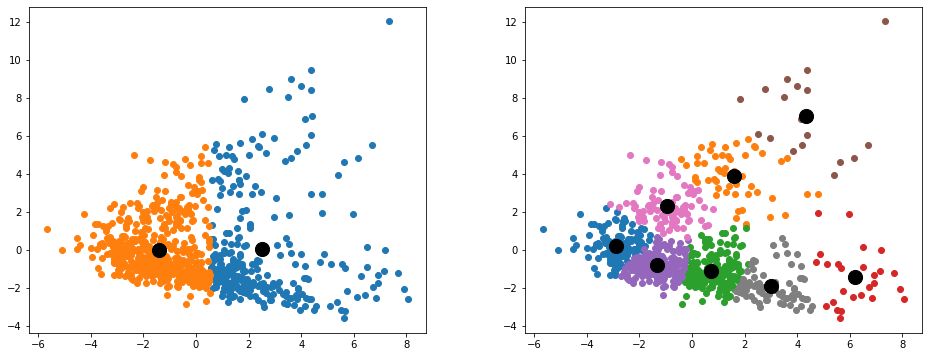

In [107]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(wspace=0.25)

# Left graph

kmeans = KMeans(n_clusters = N_CLUSTERS)

predict_X = kmeans.fit_predict(new_X)

centers = kmeans.cluster_centers_

for i in np.unique(predict_X):
    ax[0].scatter(new_X[predict_X == i, 0], new_X[predict_X == i, 1], label = i)
    
ax[0].scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=1);

# Right graph

kmeans = KMeans()

predict_X = kmeans.fit_predict(new_X)

centers = kmeans.cluster_centers_

for i in np.unique(predict_X):
    ax[1].scatter(new_X[predict_X == i, 0], new_X[predict_X == i, 1], label = i)
    
ax[1].scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=1);

#### 3.2

### Answer:
I originally ran the data with 2 clusters, which I thought was fitting based on the Yes/No values of the Private column of the data. But the question got me thinking what would happen if I let the algorithm decide how many clusters there should be.

So I plotted these side by side to compare the results.

Based on the results I can conclude that the algorithm has clustered the data based on all the other columns in the dataframe. Assuming this is true, that means the graph on the right is clustered based on private or not, and on their performance, enrollment, etc.. while the graph on the left only takes into account private vs. public. 

Though if we compare the position of the dots on the left graph vs. the right graph, we can see that some of the dots on the split of orange and blue in the left graph now belong to a cluster that spans that split and more on the right graph. Specifically at coordinates (0.5, -2), (0.5, 2), and (0.5, 4) we can see this is even more obvious.

In the end I think that 2 clusters are probably better. The clustering is a bit tighter and on the algorithm's version but it also seems like the data might be missrepresented, while on my version the split is very clear.